# Kod

In [ ]:
#!/usr/bin/env bash

set -x

mpiexec  -machinefile ./same_host -np 2 ./timer.py | tee results/1_shm_host.csv
MPIR_CVAR_CH3_NOLOCAL=1 mpiexec  -machinefile ./same_host -np 2 ./timer.py | tee results/2_net_host.csv
MPIR_CVAR_CH3_NOLOCAL=1 mpiexec  -machinefile ./same_machine -np 2 ./timer.py | tee results/3_net_machine.csv
MPIR_CVAR_CH3_NOLOCAL=1 mpiexec -machinefile ./different_machine -np 2 ./timer.py | tee results/4_net_diff.csv

* same_host 
 - `vnode-03.dydaktyka.icsr.agh.edu.pl:2`
* same_machine 
 - `vnode-02.dydaktyka.icsr.agh.edu.pl:1`
 - `vnode-03.dydaktyka.icsr.agh.edu.pl:1`
* different_machine
 - `vnode-03.dydaktyka.icsr.agh.edu.pl:1`
 - `vnode-04.dydaktyka.icsr.agh.edu.pl:1`

In [ ]:
#!/usr/bin/env python2
import sys
import gc
import numpy as np
from mpi4py import MPI


def gen_lengths(max_len):
    x = 1
    while x < max_len:
        yield int(x)
        if x < 50:
            x += 5
        else:
            x *= 1.8

if __name__ == "__main__":
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    results = []
    iterations = 100

    for i in range(3):
        rst = []
        for payload_size in gen_lengths(max_len=(2**26)):

            payload_bytes = bytearray(payload_size)
            gc.collect()

            comm.Barrier()
            start_reg = MPI.Wtime()
            for _ in xrange(iterations):
                if rank == 0:
                    comm.Send(payload_bytes, dest=1)
                elif rank == 1:
                    comm.Recv(source=0)
            end_reg = MPI.Wtime()

            comm.Barrier()
            start_sync = MPI.Wtime()
            for _ in xrange(iterations):
                if rank == 0:
                    comm.Ssend(payload_bytes, dest=1)
                elif rank == 1:
                    comm.Recv(source=0)
            end_sync = MPI.Wtime()
            comm.Barrier()

            m_bit_per_second_reg = ((8 * payload_size * iterations)/(end_reg - start_reg)) / 10**6
            m_bit_per_second_sync = ((8 * payload_size * iterations)/(end_sync - start_sync)) / 10**6
            rst.append((payload_size, m_bit_per_second_reg, m_bit_per_second_sync))
        results.append(rst)
        
    if rank == 0:
        x = np.array(results)
        x = np.array(x.transpose().mean(axis=-1)).transpose()
        print 'size;bandwidth(reg);bandwidth(sync)'
        for r in x:
            print '%d;%f;%f' % (r[0], r[1], r[2])          

# Sprawozdanie

In [ ]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd

In [2]:
%matplotlib inline

## Parametry
* Tryby komunikacji: standardowy i synchronizowany
* Każdy pomiar był przeprowadzany 3 razy, końcowy wynik to średnia
* Przepustowość: `(8 * payload_size * iterations)/(end - start)) / 10**6`, gdzie `iterations = 100`
* Payload: `payload = bytearray(payload_size)`, w rozmiarach od ***1 B*** do ***28 MB***

## Opóźnienia

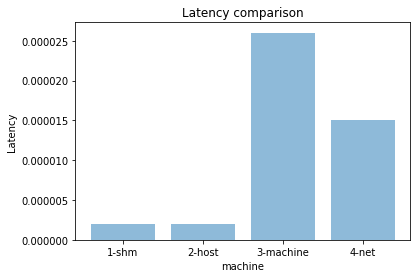

In [16]:
x = ('1-shm', '2-host', '3-machine', '4-net')
lts = [0.000002, 0.000002, 0.000026, 0.000015]
y_pos = np.arange(len(x))
 
plt.bar(y_pos, lts, align='center', alpha=0.5)
plt.xticks(y_pos, x)
plt.ylabel('Latency')
plt.xlabel('machine')
plt.title('Latency comparison')
 
plt.show()

## Ten sam host - pamiec współdzielona

In [3]:
path = "results/1_shm_big.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,3.600000e+01,36.000000,36.000000
mean,1.985375e+06,22475.909181,21293.296191
std,5.812568e+06,23722.313083,23970.114530
min,1.000000e+00,4.568944,3.533042
25%,4.475000e+01,260.659166,165.532263
50%,2.824500e+03,13830.921231,8026.287314
75%,2.916020e+05,41476.457120,42447.373061
max,2.943020e+07,66713.301275,66890.643165


Text(0.5, 0, 'Size [ B ]')

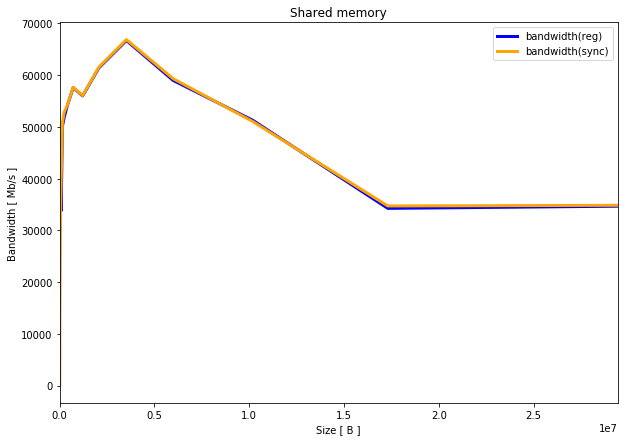

In [4]:
p = times.plot(x='size', title='Shared memory', figsize=(10,7), color=['blue', 'orange'], linewidth=3)
p.set_ylabel("Bandwidth [ Mb/s ]")
p.set_xlabel("Size [ B ]")

## Ten sam host - sieć (nie działa)

In [5]:
path = "results/2_host_big.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,3.600000e+01,36.000000,36.000000
mean,1.985375e+06,22655.565899,21277.424431
std,5.812568e+06,23731.550668,23942.809713
min,1.000000e+00,4.127375,3.629974
25%,4.475000e+01,271.497925,163.560053
50%,2.824500e+03,14620.278117,8103.480572
75%,2.916020e+05,41510.310572,42757.525200
max,2.943020e+07,65305.299371,65518.662114


Text(0.5, 0, 'Size [ B ]')

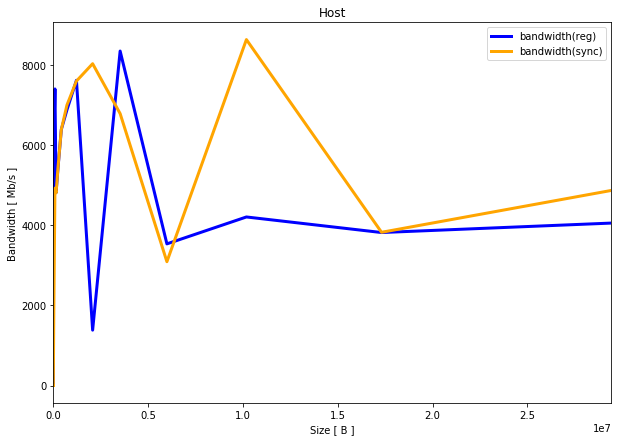

In [12]:
p = times.plot(x='size', title='Host', figsize=(10,7), color=['blue', 'orange'], linewidth=3)
p.set_ylabel("Bandwidth [ Mb/s ]")
p.set_xlabel("Size [ B ]")

## Ta sama maszyna

In [8]:
path = "results/3_machine_big.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,3.600000e+01,36.000000,36.000000
mean,1.985375e+06,2563.007598,2219.758059
std,5.812568e+06,2823.651274,2909.953973
min,1.000000e+00,0.366830,0.093643
25%,4.475000e+01,15.836545,3.746323
50%,2.824500e+03,1160.162020,232.150281
75%,2.916020e+05,4538.300616,4820.545191
max,2.943020e+07,8341.423948,8627.391314


Text(0.5, 0, 'Size [ B ]')

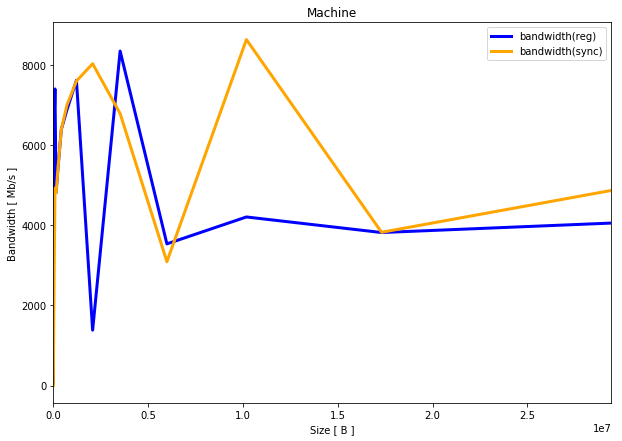

In [13]:
p = times.plot(x='size', title='Machine', figsize=(10,7), color=['blue', 'orange'], linewidth=3)
p.set_ylabel("Bandwidth [ Mb/s ]")
p.set_xlabel("Size [ B ]")

## Różne maszyny

In [14]:
path = "results/4_net.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,3.600000e+01,36.000000,36.000000
mean,1.985375e+06,1128.278020,570.745129
std,5.812568e+06,1169.334857,723.342355
min,1.000000e+00,0.433318,0.022071
25%,4.475000e+01,21.449004,2.831413
50%,2.824500e+03,1079.690584,110.580276
75%,2.916020e+05,1691.461499,1348.644426
max,2.943020e+07,3866.415427,2504.082852


Text(0.5, 0, 'Size [ B ]')

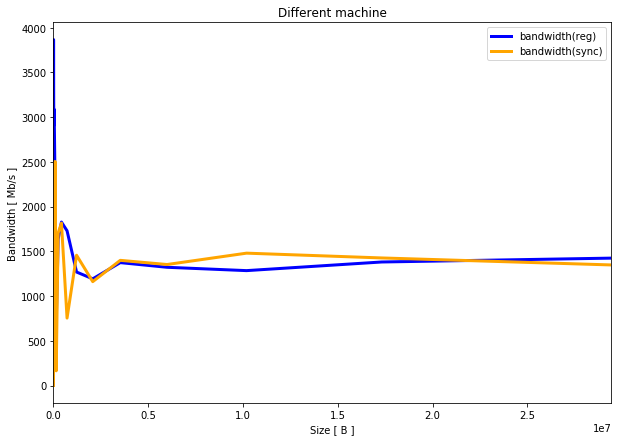

In [15]:
p = times.plot(x='size', title='Different machine', figsize=(10,7), color=['blue', 'orange'], linewidth=3)
p.set_ylabel("Bandwidth [ Mb/s ]")
p.set_xlabel("Size [ B ]")

Porównanie wszystkich typów hostów (obraz w md)
![title](results/5_mix.png)

# Podsumowanie

* Wynik pomiaru *'2-host'* nie jest zogdny z przewidywaniami. Komunikacja przez pamięć powinna być szybsza.
* Najprawdopodobniej zmienna środowiskowa `MPIR_CVAR_CH3_NOLOCAL=1` wymuszające użycie komunikacji przez sieć nie działa dla implementacji MPI w Pythonie. Została ona wprowadzone w wersji ***3.0.4***
* Na vnode'ach jest wersja ***3.2***

# Uwagi prowadzącego przy oddawaniu (błędy)
* W pythonie trzeba użyć funkcji Send() i Recv(), a nie send() i recv(). (serializacja)
* Czas należy mierzyć dopiero jak wiemy, że odebraliśmy komunikat. i.e. `if rank == 1: end = MPI.Wtime()`